## Tutorial
### Quick start
Create pipeline task with task decorators:

In [17]:
import lazy_pipe


@lazy_pipe.task
def run_a(param):
    return f"Output of A with {param}"

@lazy_pipe.task
def run_b(a):
    return f"Output of B with {a}"

@lazy_pipe.task
def run_c(b):
    return f"Output of C with {b}"

Link them:

In [18]:
a = run_a(param="Initial input for A")
b = run_b(a)
c = run_c(b)

Define pipeline:

In [19]:
simple_pipeline = lazy_pipe.Pipeline(
  input=a,
  outputs=[c]
)

Visualize:  


*Note: This step would only works if you will have properly installed Graphviz on your computer.*

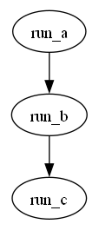

In [22]:
lazy_pipe.visualize(simple_pipeline)

### Functionality overview

#### Task
Two types of tasks are supported:
1. Function task defined with `task` decorator

In [23]:
@lazy_pipe.task
def A(param):
    return f"Output of A with {param}"

@lazy_pipe.task
def B(a):
    return f"Output of B with {a}"

@lazy_pipe.task
def C(b):
    return f"Output of C with {b}"

@lazy_pipe.task
def D(a, c):
    return f"Output of D with {a} and {c}"

2. Method tasks defined with `method_task` decorator

In [24]:
class ExampleClass:
    @lazy_pipe.method_task
    def E(self, d):
        return f"Output of E with {d}"

    @lazy_pipe.method_task
    def F(self, e):
        return f"Output of F with {e}"

    @lazy_pipe.method_task
    def G(self, inp):
        return f"Output of G with {inp}"

    @lazy_pipe.method_task
    def __call__(self, inp):
        return f"Output from Exampleclass with {inp}"

Tasks flow is defined in very intuitive way (like normal functions execution).  
Note that:
1. You can mix in single pipeline tasks with methods tasks.
2. You can put more tasks to single task   

In [40]:
example = ExampleClass()

a = A(param="Initial input for A")
b = B(a)
c = C(b)
d = D(a, c)
e = example.E(d)
f = example.F(e)
g = example.G(c)
ec = example(g)

#### Pipeline
To define pipeline simply pass input and outputs to Pipeline.  
You can define as many output as you want, but only one input.


In [41]:
pipeline = lazy_pipe.Pipeline(input=a, outputs=[f, ec])

You can run the same pipeline with different parameters. Your result would be a list with values for each defined output.

In [ ]:
result = pipeline.run()
print(result)

new_result = pipeline.run(param="## New input for A ##")
print(new_result)

new_result2 = pipeline.run(param="@@ New input for A @@")
print(new_result2)


['Output of F with Output of E with Output of D with Output of A with Initial input for A and Output of C with Output of B with Output of A with Initial input for A', 'Output from Exampleclass with Output of G with Output of C with Output of B with Output of A with Initial input for A']
['Output of F with Output of E with Output of D with Output of A with ## New input for A ## and Output of C with Output of B with Output of A with ## New input for A ##', 'Output from Exampleclass with Output of G with Output of C with Output of B with Output of A with ## New input for A ##']
['Output of F with Output of E with Output of D with Output of A with @@ New input for A @@ and Output of C with Output of B with Output of A with @@ New input for A @@', 'Output from Exampleclass with Output of G with Output of C with Output of B with Output of A with @@ New input for A @@']


But be aware, that when you run it again without parameters it will use last defined parameter

In [ ]:
result = pipeline.run()
print(result)

['Output of F with Output of E with Output of D with Output of A with @@ New input for A @@ and Output of C with Output of B with Output of A with @@ New input for A @@', 'Output from Exampleclass with Output of G with Output of C with Output of B with Output of A with @@ New input for A @@']


`visualize` function create `matplotlib` plot that you can customize.  

Alternatively you can save visualization fo file instead of plotting, by specifying parameter to_file: `lazy_pipe.visualize(pipeline, to_file="path/to/file")`


Tasks are named with theirs functions names. Method tasks like `ClassName.function_name`, but there is one special case: `__call__` method is named only with class name.
  

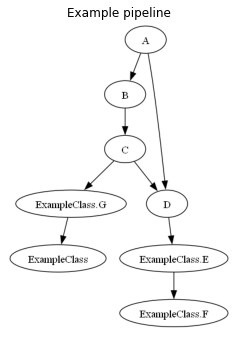

In [42]:
import matplotlib.pyplot as plt


lazy_pipe.visualize(pipeline)
plt.title("Example pipeline")
plt.gcf().set_size_inches(4, 6)


### Dig deeper 
`lazy_pipe.task` decorator change function behavior in a way that when it is called it saves base function with its arguments to `Task` object instead of calling it. 

In [11]:
@lazy_pipe.task
def foo(x):
  return x

x = 1
print(f"x type before foo processing - {type(x)}")
x = foo(x)
print(f"x type after  foo processing - {type(x)}")

x type before foo processing - <class 'int'>
x type after  foo processing - <class 'lazy_pipe.task_core.Task'>


You can check values that are stored by Task x:

In [9]:
print("Stored function:", x.func)
print("Stored args: \t", x.args)
print("Stored kwargs: \t", x.kwargs)

Stored function: <function foo at 0x000001CBE13D7B50>
Stored args: 	 (1,)
Stored kwargs: 	 {}


If you want run stored function, it is possible with `run` method, but normally `Pipeline` object would do it for you.

In [10]:
x.run()

1

Task stores information about input arguments that that are provided to it, so when you put another Task as input to your task, it will have information about function that should be run before.  

In [15]:
@lazy_pipe.task
def foo2(x):
  return x

inp = 1
x = foo(inp)
x2 = foo2(x)

print(f"input arg for x2 is '{x2.args[0]}' which type is {type(x2.args[0])}")

input arg for x2 is 'foo' which type is <class 'lazy_pipe.task_core.Task'>


Basically tuple (*task*, *task argument*) is edge of directional computing graph. `lazy_pipe.Pipeline` collect information about all edges, and sort them in right execution order. After that you can run whole pipeline. 

In [16]:
pipeline = lazy_pipe.Pipeline(input=x, outputs=[x2])
pipeline.run()

[1]